### Model 1 - level 1 codes; base of dx and pcs

    Step 1 : Read the processed files pat_adm(latest encounter), pat_med(medications),diagnoses_rbase,procedures_rbase,labs
    Step 2: Join pat_adm (required_columns) with diagnoses_rbase and do OHE
    Step 3: Join pat_adm (required_columns) with procedures_rbase and do OHE    
    Step 4: If more than 95% is missing , drop the column  for each df
    Step 5: Medications - OHE; again if more than 95% missing, drop the columns
    Step 6:Add labs, add demographics data, Add target variable - increase_flag    

### Model 1 - level 2 codes; granular

    Step 1 : Read the files pat_adm(latest encounter), pat_med(medications),diagnoses_r,procedures_r,labs
    Step 2: Join pat_adm (required_columns) with diagnoses_rbase and do OHE
    Step 3: Join pat_adm (required_columns) with procedures_rbase and do OHE    
    Step 4: If more than 95% is missing , drop the column  for each df
    Step 5: Medications - OHE; again if more than 95% missing, drop the columns
    Step 6:Add labs, add demographics data, Add target variable - increase_flag 

In [1]:
import pandas as pd
#!pip install imblearn
#!pip install scikit-learn==1.2.2
# check version number
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from datetime import timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
#!pip install numpy
#import shap
hosp='W:\\Main_project\\mimic-iv-2.2\\mimic-iv-2.2\\hosp\\'
icu='W:\\Main_project\\mimic-iv-2.2\\mimic-iv-2.2\\icu\\'
base='W:\\Main_project\\base_files\\'
#!pip install shap

In [2]:
pat_adm=pd.read_csv(f'{base}pat_adm_aki_time_final.csv')

In [3]:
#Categorize the race

prefix_mapping = {
    'WHITE': 'White',
    'BLACK': 'Black',
    'UNKNOWN': 'Unknown',
    'HISPANIC/LATINO': 'Hispanic/Latino',
    'HISPANIC OR LATINO': 'Hispanic/Latino',
    'ASIAN': 'Asian'
}

# Update the values in the 'race' column
for prefix, new_name in prefix_mapping.items():
    pat_adm.loc[pat_adm['race'].str.startswith(prefix), 'race'] = new_name
print(pat_adm['race'].unique())    

['Black' 'Unknown' 'White' 'Asian' 'Hispanic/Latino' 'OTHER'
 'UNABLE TO OBTAIN' 'PORTUGUESE' 'PATIENT DECLINED TO ANSWER'
 'AMERICAN INDIAN/ALASKA NATIVE' 'MULTIPLE RACE/ETHNICITY'
 'SOUTH AMERICAN' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']


In [4]:
pat_labs=pd.read_csv(f'{base}labs_final.csv',index_col=0)
print(pat_labs['subject_id'].nunique())


pat_procedures_rbase=pd.read_csv(f'{base}procedures_r.csv',index_col=0)
print(pat_procedures_rbase['subject_id'].nunique())

pat_med=pd.read_csv(f'{base}RxNorm_base_file.csv',index_col=0,dtype=str,on_bad_lines='warn')
print(pat_med['subject_id'].nunique())
pat_med['RXCUI'].fillna(pat_med['drug'], inplace=True)

print(pat_med[pat_med['RXCUI'].isnull()]['subject_id'].nunique()) #80 drugs wihput rxcui/ndc #907 patients??

27111
9414
26596
0


In [5]:
#Get required columns only 
pat_diagnoses_rbase=pd.read_csv(f'{base}diagnoses_r.csv',index_col=0)
pat_adm=pat_adm[['subject_id', 'gender','race', 'age','increase_flag']]
pat_med=pat_med[['subject_id','RXCUI']]
pat_labs=pat_labs[['subject_id','creatinine', 'albumin' , 'alt', 'bilirubin',  'ast',  'bun',  'glucose', 'ammonia',  'ck']]
pat_diagnoses_rbase=pat_diagnoses_rbase[['subject_id','icd_code']]
pat_procedures_rbase=pat_procedures_rbase[['subject_id','icd_code']]

In [6]:
print(pat_diagnoses_rbase.shape)
print(pat_procedures_rbase.shape)

pat_procedures_rbase=pat_procedures_rbase.drop_duplicates()
pat_diagnoses_rbase=pat_diagnoses_rbase.drop_duplicates()

print(pat_diagnoses_rbase.shape)
print(pat_procedures_rbase.shape)

print(pat_med.shape)
pat_med=pat_med.drop_duplicates()
print(pat_med.shape)

(908751, 2)
(330057, 2)
(548713, 2)
(328308, 2)
(1059651, 2)
(703273, 2)


In [7]:
#OHE - procedures_base
pat_proc_ohe = pd.get_dummies(pat_procedures_rbase.set_index('subject_id'), prefix='p').astype(int)
pat_proc_ohe = pat_proc_ohe.groupby('subject_id').max().reset_index() #510 columns
print (pat_proc_ohe.shape)


#Check for any columns with less than 95%, drop them
percentage_zeros = (pat_proc_ohe.drop('subject_id', axis=1) == 0).mean()
columns_to_drop = percentage_zeros[percentage_zeros > 0.95].index
pat_proc_ohe = pat_proc_ohe.drop(columns_to_drop, axis=1)
print(pat_proc_ohe.shape)

del pat_procedures_rbase

(9414, 20873)
(9414, 81)


In [8]:
#medications
pat_med_ohe = pd.get_dummies(pat_med.set_index('subject_id'), prefix='m').astype(int)
pat_med_ohe = pat_med_ohe.groupby('subject_id').max().reset_index() #510 columns
print (pat_med_ohe.shape)



#Check for any columns with less than 97%, drop them
percentage_zeros = (pat_med_ohe.drop('subject_id', axis=1) == 0).mean()
columns_to_drop = percentage_zeros[percentage_zeros > 0.95].index
pat_med_ohe = pat_med_ohe.drop(columns_to_drop, axis=1)
print(pat_med_ohe.shape)
pat_med_ohe.head()
pat_med_ohe=pat_med_ohe.drop('m_ N/A',axis=1)
print(pat_med_ohe.shape)

del pat_med

(26596, 3105)
(26596, 117)
(26596, 116)


In [9]:
#Drop columns with more than 75% missing

pat_labs=pat_labs[['subject_id', 'creatinine', 'albumin', 'alt', 
       'bilirubin',  'ast', 'bun',    'glucose', 'ammonia',  'ck']]
missing_percentages = (pat_labs.isnull().sum() / len(pat_labs)) * 100
columns_with_high_missing_values = missing_percentages[missing_percentages > 75].index
pat_labs = pat_labs.drop(columns_with_high_missing_values, axis=1)


In [10]:
#OHE - diagnoses_base
pat_diagnoses_ohe = pd.get_dummies(pat_diagnoses_rbase.set_index('subject_id'), prefix='d').astype(int)
pat_diagnoses_ohe = pat_diagnoses_ohe.groupby('subject_id').max().reset_index() #510 columns
print (pat_diagnoses_ohe.shape)



#Check for any columns with less than 97%, drop them
percentage_zeros = (pat_diagnoses_ohe.drop('subject_id', axis=1) == 0).mean()
columns_to_drop = percentage_zeros[percentage_zeros > 0.95].index
pat_diagnoses_ohe = pat_diagnoses_ohe.drop(columns_to_drop, axis=1)
print(pat_diagnoses_ohe.shape)

(14619, 13410)
(14619, 120)


In [11]:

#Join to a single df

pat_med_ohe['subject_id']=pat_med_ohe['subject_id'].astype(int)
df1=pd.merge(pat_adm,pat_med_ohe,how='left',on='subject_id')

m_columns = [col for col in df1.columns if col.startswith('m_')] #fill null with 0, since they are not present
df1[m_columns] = df1[m_columns].fillna(0).astype(int)
df1['increase_flag'] = df1['increase_flag'].astype(int)


df2=pd.merge(df1,pat_proc_ohe,how='left',on='subject_id')
p_columns = [col for col in df2.columns if col.startswith('p_')] #fill null with 0, since they are not present
df2[p_columns] = df2[p_columns].fillna(0).astype(int)


df3=pd.merge(df2,pat_diagnoses_ohe,how='left',on='subject_id')
d_columns = [col for col in df3.columns if col.startswith('d_')] #fill null with 0, since they are not present
df3[d_columns] = df3[d_columns].fillna(0).astype(int)


df4=pd.merge(df3,pat_labs,how='left',on='subject_id') # final df

### Divide the dataset and stratify
### Define the numeric,categorical variables

In [12]:
X = df4.drop(columns=['increase_flag','subject_id'])  # Features
y = df4['increase_flag']  # Target variable


rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the dataset into training and testing sets with a 70:30 ratio, stratified on 'flag'
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3,random_state=42)

# Print the shapes of the resulting datasets
print("Shapes of the datasets:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of the datasets:
X_train: (8104, 324)
X_test: (3474, 324)
y_train: (8104,)
y_test: (3474,)


In [13]:
print(y_train.value_counts())
print(y_test.value_counts())



increase_flag
1    4080
0    4024
Name: count, dtype: int64
increase_flag
0    1765
1    1709
Name: count, dtype: int64


In [14]:
numeric_features = ['creatinine','albumin','alt','bilirubin','ast','bun','glucose','age']
categorical_features = ['gender','race']
remaining_features = [col for col in X_train.columns if col not in numeric_features + categorical_features]
#remaining_features

### Preprocessing

### Outlier

In [15]:
X_train[numeric_features].describe() # outliers are there

,creatinine,albumin,alt,bilirubin,ast,bun,glucose,age
count,7531.000000,3065.000000,4322.000000,4192.000000,4349.000000,6777.000000,7480.000000,8104.000000
mean,1.018311,3.315530,49.923646,1.376789,50.646815,21.321676,118.617246,67.775913
std,0.525391,0.650713,156.230465,3.860158,125.888562,15.474942,45.480394,18.244798
min,0.000000,1.300000,1.000000,0.000000,0.000000,1.000000,20.000000,18.000000
25%,0.700000,2.900000,14.000000,0.300000,18.000000,12.000000,91.000000,57.000000
50%,0.900000,3.300000,22.000000,0.500000,26.000000,17.000000,106.000000,70.000000
75%,1.200000,3.800000,39.000000,0.900000,43.000000,26.000000,130.250000,82.000000
max,4.600000,6.400000,5065.000000,54.900000,3395.000000,158.000000,779.000000,101.000000


In [16]:
from sklearn.preprocessing import FunctionTransformer
def outlier_removal(X):
    X = pd.DataFrame(X).copy()
    for i in range(X.shape[1]):
        x = pd.Series(X.iloc[:,i]).copy()
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (10 * iqr)
        upper_bound = q3 + (10 * iqr)
        x.index = np.arange(len(x))
        outliers_mask= (X.iloc[:,i] < lower_bound) | (X.iloc[:,i] > upper_bound)
        median_val = x.median()
        X.loc[outliers_mask, i] = median_val
    return X
outlier_removal = FunctionTransformer(outlier_removal)

### Correlation matrix

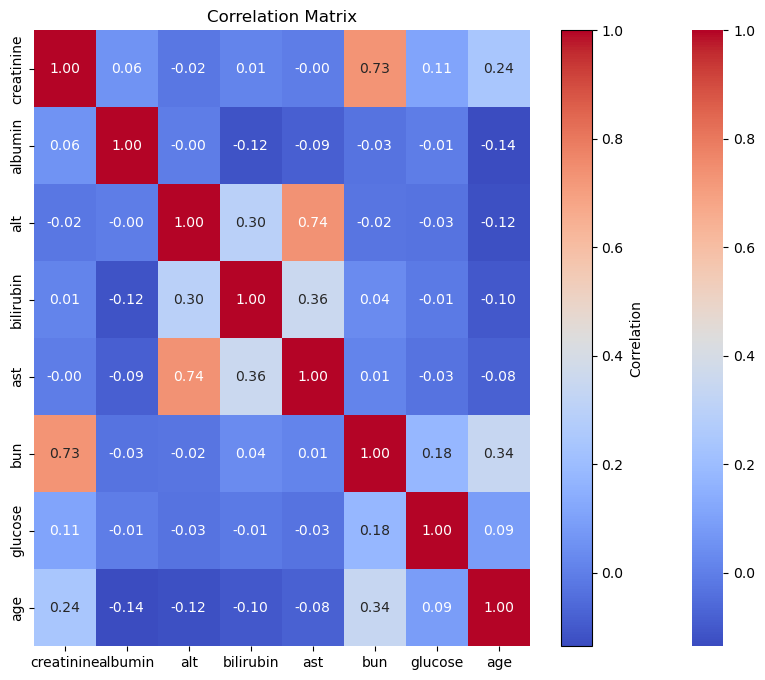

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix=X_train[numeric_features].corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")

# Add a colorbar as a legend
cbar = plt.colorbar(heatmap.collections[0])
cbar.set_label('Correlation')

# Set the title and display the plot
plt.title('Correlation Matrix')
plt.show()

### Column transformer and preprocessor

In [18]:
from sklearn.feature_selection import RFE

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('outlier_remover', outlier_removal),  # Remove outliers
    ('scaler', StandardScaler()),  # Scale numerical features
])


categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])




preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numeric_features),  # Apply numerical pipeline to numerical features
    ('cat', categorical_pipeline, categorical_features),  # Apply categorical pipeline to categorical features
],
  remainder='passthrough'
)


In [19]:
# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42)) 
])
pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier_remover',
                                                                   FunctionTransformer(func=<function outlier_removal at 0x000001798872E040>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['creatinine', 'albumin',
                                                   'alt', 'bilirubin', 'ast',
                                                   'bun', 'glucose', 'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'race'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [20]:

# Define hyperparameters for random search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 7,9],
   'classifier__min_samples_split': [2, 5, 10,12],
    'classifier__min_samples_leaf': [1, 2, 4]
}

from sklearn.metrics import make_scorer, average_precision_score


#pr_auc_scorer = make_scorer(average_precision_score)

random_search = RandomizedSearchCV(pipeline, 
                                   param_grid, n_iter=20,
                                   cv=StratifiedKFold(5,shuffle=True,random_state=42), 
                                   scoring='roc_auc', 
                                   refit=True,verbose=2)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__min_samples_split=12, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=200; total time=   0.6s
[CV] END classifier__max_depth=5, classifier

[CV] END classifier__max_depth=9, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   1.1s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   1.1s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   1.1s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   1.1s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   1.1s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.3s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier_

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('outlier_remover',
                                                                                                FunctionTransformer(func=<function outlier_removal at 0x000001798872E040>)),
                                                                                               ('scaler',
                                                                                                Sta...
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['gender',
                                                                                'race'])])),
                                             ('classifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=20,
                   param_distributions={'classifier__max_depth': [5, 7, 9],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10,
                                                                          12],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   scoring='roc_auc', verbose=2)

In [21]:
random_search.best_params_

{'classifier__n_estimators': 300,
 'classifier__min_samples_split': 12,
 'classifier__min_samples_leaf': 4,
 'classifier__max_depth': 9}

In [22]:
cv_results = random_search.cv_results_
avg_auc_roc_score = np.mean(cv_results['mean_test_score'])
print("Average roc_auc score across cross-validations:", avg_auc_roc_score)


Average roc_auc score across cross-validations: 0.7901085589438025


In [23]:
best_estimator=random_search.best_estimator_

In [24]:
# Print the performance metrics of training

y_train_pred=best_estimator.predict(X_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
roc_auc = roc_auc_score(y_train, y_train_pred)

print("Training Performance Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Training Performance Metrics:
Precision: 0.8118811881188119
Recall: 0.7235294117647059
F1 Score: 0.7651632970451011
ROC AUC Score: 0.7767746462402059


In [25]:
# Predict the labels for the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = best_estimator.predict(X_test) 

# Calculate different performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Test Performance Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Test Performance Metrics:
Precision: 0.7675324675324675
Recall: 0.6916325336454067
F1 Score: 0.7276084949215142
ROC AUC Score: 0.7443998362278026


In [26]:
#feature_list=X.columns.tolist()
#drop_columns=['gender', 'race','age'] 
#feature_list=[x for x in feature_list if x not in drop_columns]

In [27]:
#cat_feature_names=list(best_estimator.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out())
#Using the order in X,
#all_feature_names = cat_feature_names + ['age']+ feature_list

In [28]:
#correct 

fitted_preprocessor = random_search.best_estimator_.named_steps['preprocessor']
num_features_transformed = numeric_features
cat_features_transformed = fitted_preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
transformed_feature_names = list(num_features_transformed) + list(cat_features_transformed) + list(X_train.columns.difference(numeric_features + categorical_features))

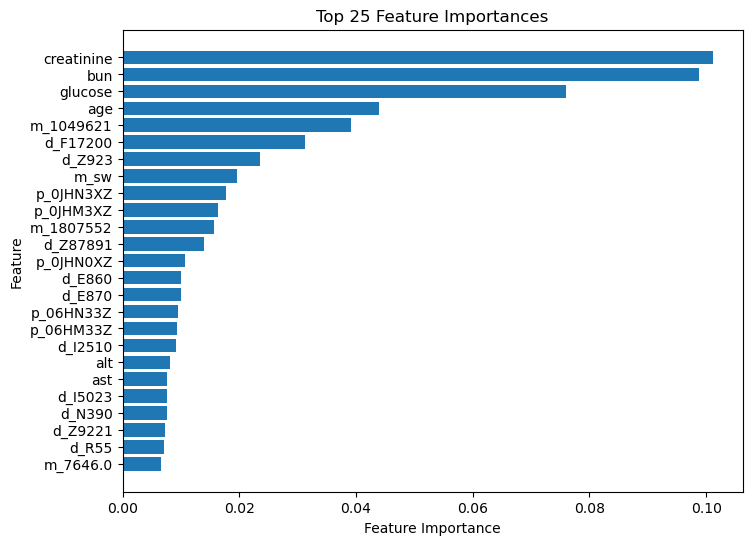

In [29]:
import matplotlib.pyplot as plt

# Assuming best_estimator is your trained Random Forest model

# Get feature importances from the Random Forest model
importances = best_estimator.named_steps['classifier'].feature_importances_

# Get feature names
feature_names = transformed_feature_names #all_feature_names

# Get indices of top 25 features
top_indices = np.argsort(importances)[::-1][:min(25, len(importances))]

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(top_indices)), importances[top_indices], align='center')
plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 25 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

In [30]:
#Remove patients who have no icd 10 codes ; save that to a file
#One hot encode diagnoses and procedures
#Remove any columns with less than 5% for all dfs
#Join to get a signle df  -- done

#Correlation matrxi
#Chi square test
#Remove unwanted columns

#Divide into X_train and X_test; strtify on target variable - increase_flag

#One hot encode
#Impute
#Scale numeric data
#RF with AUC-ROC - random search + hyperpaprameter ; use 5 fold CV
#get performance metrics
#
#Plot feature importance, shap values

#code to get missing %
'''

missing_percentages = round(((df9.isnull().sum() / len(df9)) * 100),2)

# Create a DataFrame to display missing percentages
missing_df = pd.DataFrame({'Missing Percentage': missing_percentages})
missing_df.index.name = 'Column'
missing_df=missing_df.reset_index()
print(missing_df)

'''

"\n\nmissing_percentages = round(((df9.isnull().sum() / len(df9)) * 100),2)\n\n# Create a DataFrame to display missing percentages\nmissing_df = pd.DataFrame({'Missing Percentage': missing_percentages})\nmissing_df.index.name = 'Column'\nmissing_df=missing_df.reset_index()\nprint(missing_df)\n\n"

### Confusion matrix

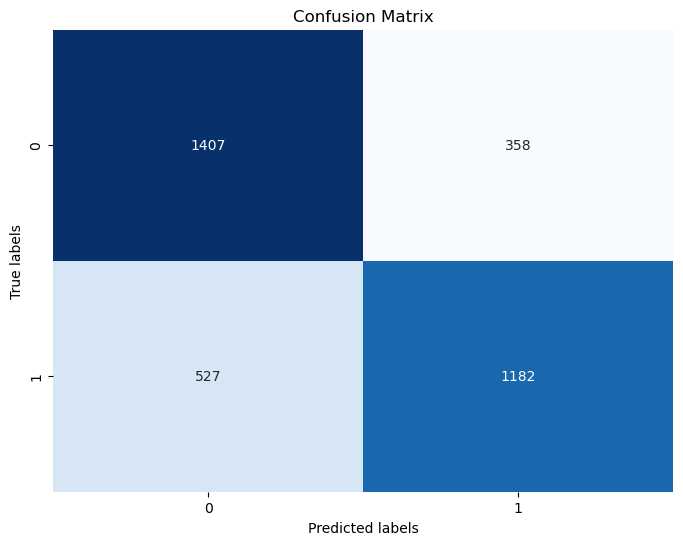

In [31]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### ROC-AUC curve

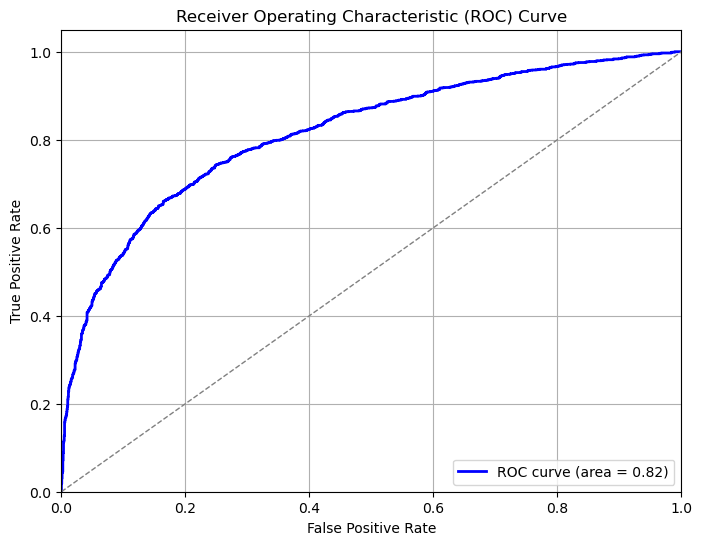

In [32]:
from sklearn.metrics import roc_curve, auc
y_prob = best_estimator.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


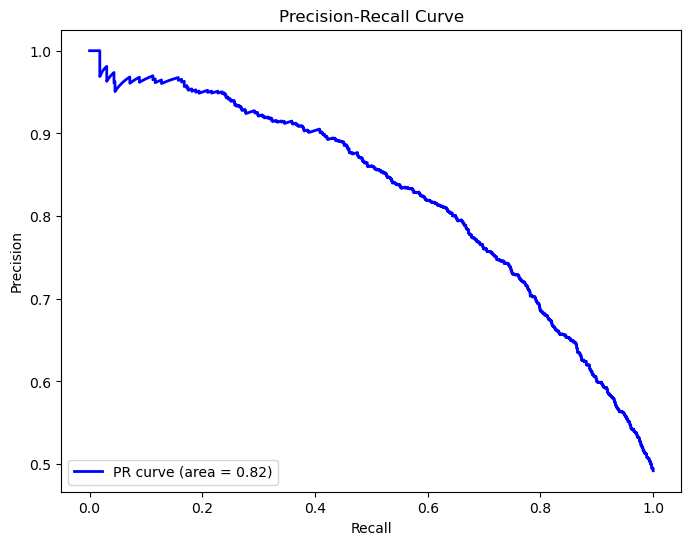

In [33]:
from sklearn.metrics import precision_recall_curve, auc
y_prob = best_estimator.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Compute PR AUC
pr_auc = auc(recall, precision)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()